# Projeto 1 - Ciência dos Dados

Nome: Enzo Junqueira

Nome: Thomas Rudge

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
c:\Users\Enzo\OneDrive - Insper - Institudo de Ensino e Pesquisa\Documentos\INSPER\2023\2-SEMESTRE\CIENCIA-DOS-DADOS\Projeto 1\Projeto1_CDADOS


Carregando a base de dados com os tweets classificados manualmente:

In [3]:
treino = pd.read_excel('dados_treino.xlsx')
treino.head()

,Mensagem,"Target: Avaliaremos quais reviews estao relacionados à utilização do Kindle, conteúdo do livro ou com erros de edição do livro (1 = Conteúdo, 2 = Amazon , 3 = Edição)",Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Comprei o livro e ele não baixou. Gostaria de ...,2,NaN,Rótulos de Linha,Contagem de Mensagem
1,"Muita enrolação, pouca informação. A autora fi...",1,NaN,1,190
2,"Não gostei, a capa diz mais do que o conteúdo ...",1,NaN,2,72
3,Estava tentando há dias continuar lendo sem qu...,1,NaN,3,38
4,Incapaz de conviver com ideias diferentes na a...,1,NaN,Total Geral,300


In [4]:
teste = pd.read_excel('dados_teste.xlsx')
teste.head()

,Mensagem,"Target: Avaliaremos quais reviews estao relacionados à utilização do Kindle, conteúdo do livro ou com erros de edição do livro (1 = Conteúdo, 2 = Amazon , 3 = Edição)",Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Como o livro se concentra na política american...,1,NaN,Rótulos de Linha,Contagem de Mensagem
1,"Boa estória. Quis ler antes de ver o filme, qu...",3,NaN,1,131
2,Não gostei. O livro o tempo todo traz narrativ...,1,NaN,2,53
3,Muito confuso.,1,NaN,3,16
4,"Comprei o livro logo após comprar ""Garota Exem...",1,NaN,(vazio),NaN


Renomearemos a coluna de rótulos para algo mais simples, como "Target".
Descartaremos as colunas desnecessárias.
Carregaremos a lista de stop words do arquivo fornecido.

In [5]:
treino.columns = ['Mensagem', 'Target', 'Drop1', 'Drop2', 'Drop3']
teste.columns = ['Mensagem', 'Target', 'Drop1', 'Drop2', 'Drop3']

treino = treino[['Mensagem', 'Target']]
teste = teste[['Mensagem', 'Target']]

In [6]:

from unidecode import unidecode

with open('stopwords.txt', 'r') as file:
    stopwords = file.read().splitlines()

stopwords = [unidecode(word.lower()) for word in stopwords]

# Splitting the single string in the stopwords_list into individual words
stopwords = stopwords[0].split(', ')


Limpar as mensagens, removendo caracteres especiais, números e pontuações.
Converter todas as palavras para minúsculas para manter a uniformidade.
Remover as stop words.

In [7]:

import re
from unidecode import unidecode

def limpa_texto(text, stopwords):
    
     # Remove acentos e caracteres especiais usando unidecode
    novo_texto = unidecode(text)

   
    # Remove todos os caracteres que não são letras ou números
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', novo_texto)


    text = cleaned_text.lower()
    
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    
    return text


# Aplica a função limpa_texto para todas as mensagens
treino['Mensagem'] = treino['Mensagem'].apply(lambda x: limpa_texto(x, stopwords))
teste['Mensagem'] = teste['Mensagem'].apply(lambda x: limpa_texto(x, stopwords))


treino.head(), teste.head()


(                                            Mensagem  Target
 0  comprei livro baixou gostaria saber vai baixar...       2
 1  enrolacao informacao autora fica contando vida...       1
 2                    gostei capa mais conteudo livro       1
 3  tentando dias continuar lendo ficasse sono inc...       1
 4  incapaz conviver ideias diferentes academia br...       1,
                                             Mensagem  Target
 0  livro concentra politica americana duas decada...       1
 1  boa estoria quis ler filme epoca fez sucesso e...       3
 2  gostei livro tempo traz narrativas cenarios eu...       1
 3                                            confuso       1
 4  comprei livro logo comprar garota exemplar sai...       1)

___
## Classificador automático


Target: Avaliaremos quais Previsãos estão relacionados à utilização do Kindle, conteúdo do livro ou com erros de edição do livro

1. Kindle: Reviews relacionados à experiência de leitura no dispositivo Kindle.
2. Conteúdo: Previsãos que discutem o conteúdo do livro, como enredo, personagens, estilo de escrita, etc.
3. Erros de Edição: Previsãos que mencionam erros de edição, como problemas de formatação, erros de impressão...


___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

1. Calcular as probabilidades a priori para cada classe (a frequência de cada classe nos dados de treinamento).
2. Calcular as probabilidades condicionais de cada palavra dada a classe (a frequência de cada palavra em cada classe nos dados de treinamento).
3. Aplicar a suavização de Laplace para lidar com palavras não vistas nos dados de treinamento.

In [8]:
# Calcula a probabilidade de cada classe
prob = treino['Target'].value_counts(normalize=True)
prob

1    0.633333
2    0.240000
3    0.126667
Name: Target, dtype: float64

As probabilidades a priori para cada classe (Target) são as seguintes:

1. Conteúdo: 63.33%
2. Kindle: 24.00%
3. Erros de Edição: 12.67%

In [9]:
# Conteúdo
conteudo = treino[treino.Target == 1]
# conteudo.head()

In [10]:
# kindle
kindle = treino[treino.Target == 2]
# kindle.head()

In [11]:
# edição
edicao = treino[treino.Target == 3]
# edicao.head()

In [12]:
from collections import Counter

# Definindo uma função para contar palavras em um DataFrame
def contar_palavras(df):
    # Concatenando todas as mensagens e dividindo em palavras
    palavras = ' '.join(df['Mensagem']).split()
    # Contando a frequência de cada palavra
    contagem_palavras = Counter(palavras)
    return contagem_palavras

# Contando as palavras em cada subcategoria
contagem_conteudo = contar_palavras(conteudo)
contagem_kindle = contar_palavras(kindle)
contagem_edicao = contar_palavras(edicao)

contagem_total = contagem_conteudo + contagem_kindle + contagem_edicao

# Exibindo as palavras mais comuns em cada subcategoria
contagem_conteudo.most_common(5), contagem_kindle.most_common(5), contagem_edicao.most_common(5)




([('livro', 236), ('mais', 85), ('ler', 47), ('historia', 46), ('ser', 44)],
 [('livro', 49), ('amazon', 34), ('mais', 32), ('livros', 30), ('preco', 25)],
 [('livro', 22), ('livros', 21), ('mais', 16), ('veio', 15), ('box', 15)])

In [13]:
# Calculando as probabilidades a priori para cada categoria
prob_priori_conteudo = len(conteudo) / len(treino)
prob_priori_kindle = len(kindle) / len(treino)
prob_priori_edicao = len(edicao) / len(treino)

# Calculando o número total de palavras em cada subcategoria
total_palavras_conteudo = sum(contagem_conteudo.values())
total_palavras_kindle = sum(contagem_kindle.values())
total_palavras_edicao = sum(contagem_edicao.values())

# Calculando o número total de palavras únicas em todo o conjunto de treinamento
total_palavras_unicas = len(set(contagem_total.keys()))

# Exibindo as probabilidades a priori e o número total de palavras
print('Probabilidade de pertencer à categoria "conteúdo": ', prob_priori_conteudo)
print('Probabilidade de pertencer à categoria "kindle": ', prob_priori_kindle)
print('Probabilidade de pertencer à categoria "edição": ', prob_priori_edicao)
print('Total de palavras na categoria "conteúdo": ', total_palavras_conteudo)
print('Total de palavras na categoria "kindle": ', total_palavras_kindle)
print('Total de palavras na categoria "edição": ', total_palavras_edicao)
print('Total de palavras únicas: ', total_palavras_unicas)


Probabilidade de pertencer à categoria "conteúdo":  0.6333333333333333
Probabilidade de pertencer à categoria "kindle":  0.24
Probabilidade de pertencer à categoria "edição":  0.12666666666666668
Total de palavras na categoria "conteúdo":  5223
Total de palavras na categoria "kindle":  1938
Total de palavras na categoria "edição":  961
Total de palavras únicas:  3382


In [14]:
def calcular_probabilidades_condicionais(contagem_palavras, total_palavras, total_palavras_unicas):
    # Suavização de Laplace
    probabilidades = {}
    for palavra, contagem in contagem_palavras.items():
        probabilidades[palavra] = (contagem + 1) / (total_palavras + total_palavras_unicas)
    return probabilidades

# Calculando as probabilidades condicionais para cada palavra dada a categoria
prob_conteudo = calcular_probabilidades_condicionais(contagem_conteudo, total_palavras_conteudo, total_palavras_unicas)
prob_kindle = calcular_probabilidades_condicionais(contagem_kindle, total_palavras_kindle, total_palavras_unicas)
prob_edicao = calcular_probabilidades_condicionais(contagem_edicao, total_palavras_edicao, total_palavras_unicas)

# Exibindo as probabilidades condicionais das primeiras palavras na categoria 'conteúdo'
list(prob_conteudo.items())[:10]


[('enrolacao', 0.00046484601975595586),
 ('informacao', 0.00023242300987797793),
 ('autora', 0.0018593840790238235),
 ('fica', 0.0008134805345729227),
 ('contando', 0.00023242300987797793),
 ('vida', 0.002556653108657757),
 ('pessoal', 0.00046484601975595586),
 ('traz', 0.00046484601975595586),
 ('informacoes', 0.0006972690296339338),
 ('relevantes', 0.00023242300987797793)]

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [15]:
import numpy as np

# Inicializar uma nova coluna no conjunto de dados de teste
teste["Previsão"] = 0

# Iterar sobre cada mensagem no conjunto de dados de teste
for i in range(len(teste["Mensagem"])):
    # Inicializar as probabilidades condicionais
    prob_cont2 = prob_kindle2 = prob_edi2 = 1
    
    # Iterar sobre cada palavra na mensagem
    for palavra in teste['Mensagem'][i].split():
        # Multiplicar as probabilidades condicionais para cada classe
        prob_cont2 *= prob_conteudo.get(palavra, (1 / (total_palavras_conteudo + total_palavras_unicas)))
        prob_kindle2 *= prob_kindle.get(palavra, (1 / (total_palavras_kindle + total_palavras_unicas)))
        prob_edi2 *= prob_edicao.get(palavra, (1 / (total_palavras_edicao + total_palavras_unicas)))
    
    # Multiplicar pelas probabilidades a priori
    prob_cont2 *= prob_priori_conteudo
    prob_kindle2 *= prob_priori_kindle
    prob_edi2 *= prob_priori_edicao
    
    # Atribuir a classe com a maior probabilidade à coluna 'Previsão'
    probabilidades = np.array([prob_cont2, prob_kindle2, prob_edi2])
    teste.loc[i, "Previsão"] = np.argmax(probabilidades) + 1

# Exibir as primeiras linhas do conjunto de dados de teste com a coluna 'Previsão' prevista
teste.head()


,Mensagem,Target,Previsão
0,livro concentra politica americana duas decada...,1,3
1,boa estoria quis ler filme epoca fez sucesso e...,3,1
2,gostei livro tempo traz narrativas cenarios eu...,1,1
3,confuso,1,1
4,comprei livro logo comprar garota exemplar sai...,1,2


In [16]:
certo = 0

t1r1 = 0
t1r2 = 0
t1r3 = 0
t2r1 = 0
t2r2 = 0
t2r3 = 0
t3r1 = 0
t3r2 = 0
t3r3 = 0

for i in range(len(teste)):
    if teste["Target"][i] == teste["Previsão"][i]:
        certo += 1

    if teste["Target"][i] == 1 and teste["Previsão"][i] == 1:
        t1r1 += 1
    elif teste["Target"][i] == 1 and teste["Previsão"][i] == 2:
        t1r2 += 1
    elif teste["Target"][i] == 1 and teste["Previsão"][i] == 3:
        t1r3 += 1
    elif teste["Target"][i] == 2 and teste["Previsão"][i] == 1:
        t2r1 += 1
    elif teste["Target"][i] == 2 and teste["Previsão"][i] == 2:
        t2r2 += 1
    elif teste["Target"][i] == 2 and teste["Previsão"][i] == 3:
        t2r3 += 1
    elif teste["Target"][i] == 3 and teste["Previsão"][i] == 1:
        t3r1 += 1
    elif teste["Target"][i] == 3 and teste["Previsão"][i] == 2:
        t3r2 += 1
    elif teste["Target"][i] == 3 and teste["Previsão"][i] == 3:
        t3r3 += 1
    



acuracia = certo / 200

print(acuracia)

print(t1r1)
print(t1r2)
print(t1r3)
print(t2r1)
print(t2r2)
print(t2r3)
print(t3r1)
print(t3r2)
print(t3r3)




0.765
103
10
18
3
42
8
6
2
8


In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Obter os rótulos verdadeiros e os rótulos previstos
rotulos_verdadeiros = teste['Target']
rotulos_previstos = teste['Previsão']

# Calcular a matriz de confusão
matriz_confusao = confusion_matrix(rotulos_verdadeiros, rotulos_previstos)

# Calcular a acurácia
acuracia = accuracy_score(rotulos_verdadeiros, rotulos_previstos)

matriz_confusao, acuracia


(array([[103,  10,  18],
        [  3,  42,   8],
        [  6,   2,   8]], dtype=int64),
 0.765)

___
### Concluindo

In [18]:
import numpy as np

def classifica_frase(frase: str) -> dict:

    # Limpar a frase
    frase = limpa_texto(frase, stopwords)
    
    # Inicializar as probabilidades condicionais
    prob_cont = prob_kind = prob_edi = 1
    
    # Calcular as probabilidades condicionais para cada palavra na frase
    for palavra in frase.split():
        prob_cont *= prob_conteudo.get(palavra, (1 / (total_palavras_conteudo + total_palavras_unicas)))
        prob_kind *= prob_kindle.get(palavra, (1 / (total_palavras_kindle + total_palavras_unicas)))
        prob_edi *= prob_edicao.get(palavra, (1 / (total_palavras_edicao + total_palavras_unicas)))

    
    # Multiplicar pelas probabilidades a priori
    prob_cont *= prob_priori_conteudo
    prob_kind *= prob_priori_kindle
    prob_edi *= prob_priori_edicao
    
    # Encontrar a classe com a maior probabilidade
    probabilidades = np.array([prob_cont, prob_kind, prob_edi])

    classe_prevista = np.argmax(probabilidades) + 1

    # if classe_prevista == 1:
    #     classe_prevista = 'Conteúdo'
    # elif classe_prevista == 2:
    #     classe_prevista = 'Kindle'
    # else:
    #     classe_prevista = 'Edição'
    
    return classe_prevista

# Testar a função com uma frase exemplo
classifica_frase('kindle kindle kindle')


2

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [19]:
# df para o excel
teste.to_excel('teste.xlsx', index=False)
treino.to_excel('treino.xlsx', index=False)

In [26]:
iteracoes = 1000
acuracias = []

for i in range(iteracoes):
    certo = 0
    teste_embaralhado = pd.concat([treino, teste])
    teste_embaralhado = teste_embaralhado[['Mensagem','Target']]
    teste_embaralhado = teste_embaralhado.sample(frac=1)
    teste_embaralhado = teste_embaralhado[:200]

    teste_embaralhado['Classificação'] = teste_embaralhado['Mensagem'].apply(classifica_frase)

    for i, row in teste_embaralhado.iterrows():
        if row["Target"] == row["Classificação"]:
            certo += 1
    acuracia = certo / len(teste_embaralhado)
    acuracias.append(acuracia)

media_acuracia = np.mean(acuracias)


In [27]:
media_acuracia

0.897145

Média das Acurácias: 0.897


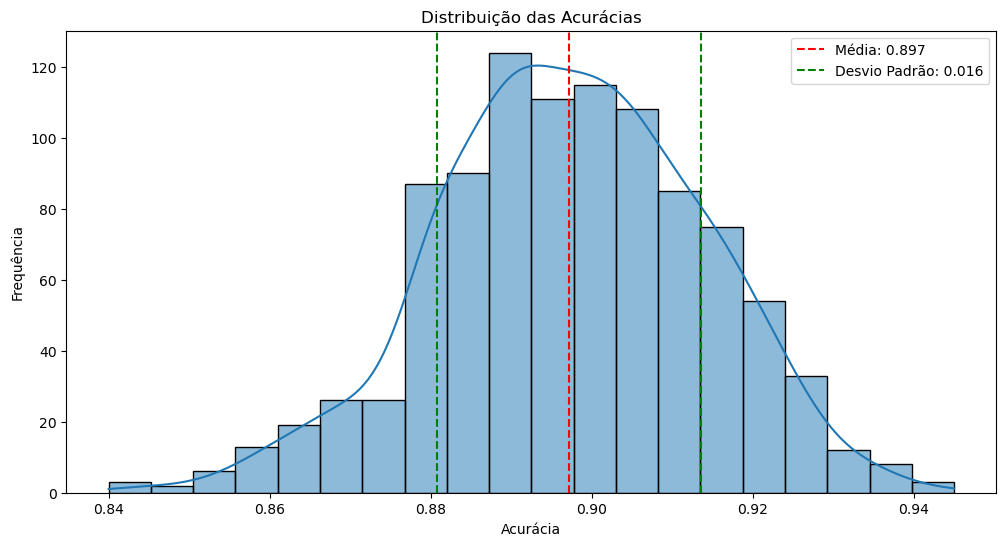

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculando a média e o desvio padrão das acurácias
media_acuracia = np.mean(acuracias)
print(f'Média das Acurácias: {media_acuracia:.3f}')
desvio_padrao_acuracia = np.std(acuracias)

# Criando o gráfico de distribuição
plt.figure(figsize=(12, 6))
sns.histplot(acuracias, kde=True, bins=20)
plt.axvline(media_acuracia, color='r', linestyle='--', label=f'Média: {media_acuracia:.3f}')
plt.axvline(media_acuracia + desvio_padrao_acuracia, color='g', linestyle='--', label=f'Desvio Padrão: {desvio_padrao_acuracia:.3f}')
plt.axvline(media_acuracia - desvio_padrao_acuracia, color='g', linestyle='--')
plt.title('Distribuição das Acurácias')
plt.xlabel('Acurácia')
plt.ylabel('Frequência')
plt.legend()
plt.show()

### Por que não usar o próprio classificador para gerar mais amostras de treinamento?
Usar o próprio classificador para gerar mais amostras de treinamento pode levar a problemas de viés e superajuste (overfitting). O modelo já foi treinado com o conjunto de dados existente e tem suas limitações e viéses baseados nesse conjunto de dados. Adicionar mais amostras geradas pelo próprio modelo só reforçará os viéses e limitações existentes, e não contribuirá para a generalização do modelo para dados não vistos. Além disso, pode levar a uma falsa sensação de precisão e confiança no modelo, já que as amostras adicionadas são, por definição, bem classificadas pelo modelo.

### Diferentes cenários para Naïve Bayes
1. Diagnóstico Médico:
O classificador Naïve Bayes pode ser usado para diagnosticar doenças com base em sintomas. Cada sintoma pode ser tratado como uma característica, e o Naïve Bayes pode ser usado para calcular a probabilidade de uma doença específica dado um conjunto de sintomas.

2. Análise de Sentimento em Redes Sociais:
O Naïve Bayes pode ser empregado para analisar o sentimento de usuários em redes sociais, classificando postagens ou comentários como positivos, negativos ou neutros. Isso pode ser útil para empresas monitorarem a opinião pública sobre seus produtos ou serviços e ajustarem suas estratégias de marketing e comunicação conforme necessário.

### Sugestões de Melhorias e Como Implementar:
1. Limpeza e Pré-processamento Avançado:
Como Implementar: Utilizar técnicas mais avançadas de processamento de linguagem natural, como a lematização, para reduzir as palavras à sua forma base e remover variações.
Referências: Bibliotecas como NLTK e SpaCy em Python oferecem ferramentas avançadas de pré-processamento de texto.
Link: https://codewithgolu.com/python/a-comprehensive-guide-to-text-preprocessing-with-nltk-and-spa-cy/

2. Balanceamento de Classes:
Como Implementar: Utilizar técnicas de reamostragem como oversampling ou undersampling para equilibrar a distribuição das classes no conjunto de treinamento.
Referências: A biblioteca imbalanced-learn em Python oferece métodos para lidar com conjuntos de dados desbalanceados. Link: https://www.analyticsvidhya.com/blog/2022/05/handling-imbalanced-data-with-imbalance-learn-in-python/

3. Otimização de Hiperparâmetros:
Como Implementar: Utilizar técnicas de otimização de hiperparâmetros, como busca em grade (Grid Search), para encontrar os melhores parâmetros para o modelo.
Referências: A biblioteca Scikit-learn em Python oferece métodos como GridSearchCV para otimização de hiperparâmetros. Link: https://pyimagesearch.com/2021/05/24/grid-search-hyperparameter-tuning-with-scikit-learn-gridsearchcv/

4. Seleção de Características:
Como Implementar: Empregar técnicas de seleção de características para identificar e manter apenas as características mais informativas e remover características redundantes ou irrelevantes.
Referências: Métodos como o teste do qui-quadrado (chi-squared test) podem ser usados para avaliar a importância das características.

5. Uso de Modelos Mais Complexos:
Como Implementar: Experimentar modelos mais avançados e complexos como Máquinas de Vetores de Suporte (SVM) ou Redes Neurais.
Referências: Frameworks como TensorFlow e PyTorch permitem a implementação de modelos mais avançados de aprendizado de máquina.


___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CONSIDEROU mais de duas categorias na variável Target e INCREMENTOU a quantidade de notícias, mantendo pelo menos 250 notícias por categoria (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* Para Target com duas categorias: CRIOU pelo menos quatro categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto (pelo menos dois cenários, exceto aqueles já apresentados em sala pelos professores: por exemplo, filtro de spam)
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item Qualidade do Classificador a partir de novas separações das Notícias entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**